In [1]:
import torch
from transformers import BertTokenizerFast

from tqdm import tqdm
import collections 

import model
from utils import inference, dataset

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,3)
import pickle

from datetime import datetime, date

In [2]:
MAX_SEQ_LEN = 100
LABEL_LIST = ["O", "B-ASP", "I-ASP", "[CLS]", "[SEP]"]
label_map = {i: label for i, label in enumerate(LABEL_LIST, 1)}
THRESHOLD_SRD = 5
NUM_POL_CLASSES = 3
LCF = 'cdw'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 2e-5
BATCH_SIZE = 8
N_EPOCHS = 60
DROPOUT_ATE = 0.1
DROPOUT_ASC = 0.1
DROPOUT_OUT = 0.1
WEIGHT_DECAY = 1e-6
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

In [4]:
ATEPCNet = model.LCF_ATEPC(MODEL_NAME, 
                           False, 
                           True, 
                           DROPOUT_ATE, 
                           DROPOUT_ASC, 
                           DROPOUT_OUT,
                           MAX_SEQ_LEN, 
                           LCF, 
                           device, 
                           NUM_POL_CLASSES)
ATEPCNet.load_state_dict(torch.load('../trained_models/showcase.pt', map_location=device))
ATEPCNet.to(device)
print('loaded!')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.pr

loaded!


Из датасета, предоставляемого сайтом Yelp, были спаршены отзывы из ресторана "Neptune Oyster". Попробуем их поанализировать 

In [5]:
with open('../data/reviews_Neptune_Oyster.pkl', 'rb') as f:
    reviews_Neptune_Oyster = pickle.load(f)

In [6]:
' '.join(reviews_Neptune_Oyster[0][0]), reviews_Neptune_Oyster[0][1]

('To die for ! Saturday lunch . Great staff , very friendly , helpful and knowledgeable . Oysters on the half , Neptune Pearls and Eros divine . Tried the sea urchin - yummy . Then the lobstah rolls . We had one hot and buttery , and one cold Mayo . Both delish and big portion the fries alone would be worth the stop .',
 datetime.date(2021, 1, 23))

In [7]:
dataset_ate = dataset.ATEPCDataset('infer_ate',
                                   'simple',
                                   [x[0] for x in reviews_Neptune_Oyster],
                                   None,
                                   None,
                                   tokenizer,
                                   MAX_SEQ_LEN,
                                   THRESHOLD_SRD,
                                   None)

In [8]:
aspects_res = inference.extract_aspects(dataset_ate, ATEPCNet, device)

In [9]:
dataset_apc = dataset.ATEPCDataset('infer_apc',
                                   'simple',
                                   [sample[0] for sample in aspects_res],
                                   [sample[1] for sample in aspects_res],
                                   [sample[2] for sample in aspects_res],
                                   tokenizer,
                                   MAX_SEQ_LEN,
                                   THRESHOLD_SRD,
                                   None)

In [10]:
result = inference.classify_polarity(dataset_apc, ATEPCNet, device)

Посмотрим на самые частоупоминаемые аспекты

In [11]:
cnt = collections.Counter()
for t in result:
    cnt[' '.join(t[1])] += 1

In [12]:
cnt.most_common(10)

[('oysters', 2053),
 ('lobster roll', 1793),
 ('wait', 1588),
 ('food', 1030),
 ('bar', 718),
 ('seafood', 644),
 ('place', 627),
 ('table', 606),
 ('service', 572),
 ('lobster', 537)]

Посчитаем статистику отзывов об устрицах этого ресторана в конкретные моменты времени, для этого разобьем отзывы по бакетам относительно времени (чтобы итоговый график был более читабелен) и в каждом бакете посчитаем среднюю оценку (0 - негативный аспект, 1 - нейтральный, 2 - позитивный)

In [13]:
num_buckets = int(len(reviews_Neptune_Oyster) / 100)
bucketed_reviews = [reviews_Neptune_Oyster[i:i+num_buckets] for i in range(0, len(reviews_Neptune_Oyster), num_buckets)]

In [14]:
data_for_plot_neptune = []
for bucket in tqdm(bucketed_reviews):
    dataset_ate = dataset.ATEPCDataset('infer_ate',
                                             'simple',
                                             [x[0] for x in bucket],
                                             None,
                                             None,
                                             tokenizer,
                                             MAX_SEQ_LEN,
                                             THRESHOLD_SRD,
                                             None)
    
    aspects_res = inference.extract_aspects(dataset_ate, ATEPCNet, device)
    
    dataset_apc = dataset.ATEPCDataset('infer_apc',
                                             'simple',
                                             [sample[0] for sample in aspects_res],
                                             [sample[1] for sample in aspects_res],
                                             [sample[2] for sample in aspects_res],
                                             tokenizer,
                                             MAX_SEQ_LEN,
                                             THRESHOLD_SRD,
                                             None)
    result = inference.classify_polarity(dataset_apc, ATEPCNet, device)
    averall_grade = 0
    num_grades = 0
    for res in result:
        if 'oysters' in ' '.join(res[1]):
            averall_grade += res[3]
            num_grades += 1
    data_for_plot_neptune.append((averall_grade / num_grades, bucket[-1][1]))

100%|██████████| 101/101 [16:58<00:00, 10.08s/it]


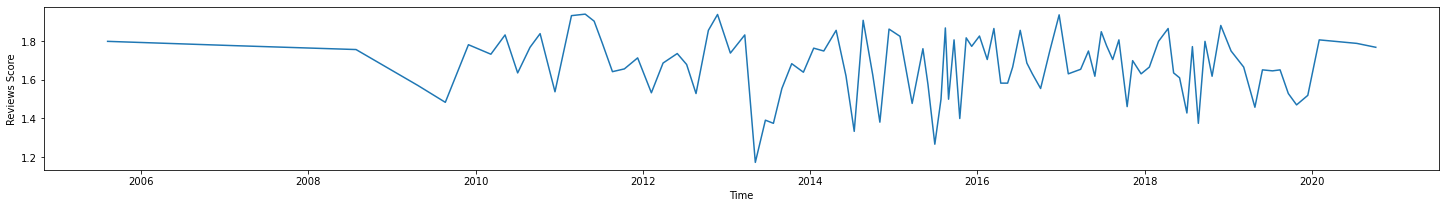

In [15]:
plt.plot([x[1] for x in data_for_plot_neptune], [x[0] for x in data_for_plot_neptune])
plt.xlabel('Time')
plt.ylabel('Reviews Score')
plt.show()